
# EmotionTeller — YOLOv11 Demo Notebook

This notebook lets you run your **EmotionTeller** emotion detection model (YOLOv11) on images, batches, videos, and webcam snapshots — and visualize predictions + export CSVs.

> **Requirements**: Python 3.10+, a recent `ultralytics` (YOLOv8/11) install, and your fine‑tuned weights (e.g., `weights/best.pt`). If using GPU, make sure you have a compatible PyTorch installed.


In [10]:

import os, io, time, glob, shutil
from pathlib import Path
from typing import List
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import torch
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

from ultralytics import YOLO
from IPython.display import display, clear_output




In [12]:
def get_available_devices() -> List[str]:
    devices = ["cpu"]
    if TORCH_AVAILABLE:
        try:
            if torch.cuda.is_available():
                devices.insert(0, "cuda")
        except Exception:
            pass
        try:
            if torch.backends.mps.is_available(): 
                devices.insert(0, "mps")
        except Exception:
            pass
    return devices

def results_to_df(results) -> pd.DataFrame:
    """Convert a single Ultralytics Results object to a tidy DataFrame."""
    if results is None or results.boxes is None or results.boxes.xyxy is None or len(results.boxes) == 0:
        return pd.DataFrame(columns=["x1","y1","x2","y2","confidence","class_id","class_name"])

    boxes = results.boxes
    xyxy = boxes.xyxy.cpu().numpy()
    conf = boxes.conf.cpu().numpy() if boxes.conf is not None else np.zeros((xyxy.shape[0],))
    cls  = boxes.cls.cpu().numpy().astype(int) if boxes.cls is not None else np.zeros((xyxy.shape[0],), dtype=int)
    names = results.names if hasattr(results, "names") else {}

    rows = []
    for i in range(xyxy.shape[0]):
        x1, y1, x2, y2 = xyxy[i]
        cid = int(cls[i]) if i < len(cls) else -1
        rows.append({
            "x1": float(x1), "y1": float(y1), "x2": float(x2), "y2": float(y2),
            "confidence": float(conf[i]), "class_id": cid, "class_name": names.get(cid, str(cid))
        })
    return pd.DataFrame(rows)

def annotate_image(results) -> Image.Image:
    """Return annotated PIL image from Ultralytics results."""
    return Image.fromarray(results.plot())

def save_df(df: pd.DataFrame, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    print(f"CSV saved to: {path}")


## Configure paths & parameters
Edit these to match your environment. If `mps` (Apple Silicon) or `cuda` (NVIDIA) is available, you can select it below.


In [ ]:

WEIGHTS = Path("last.pt")    
OUTPUT_DIR = Path("outputs")    

CONF_THRES = 0.25
IOU_THRES  = 0.45
IMG_SIZE   = 640
MAX_DET    = 300
AGNOSTIC_NMS = False
FP16 = False

DEVICES = get_available_devices()
DEVICE = DEVICES[0]  
DEVICES

['cpu']

In [14]:

# --- Load the model ---

assert WEIGHTS.exists(), f"Weights not found at {WEIGHTS.resolve()}"
model = YOLO(str(WEIGHTS))
try:
    CLASS_NAMES = model.model.names  # type: ignore
except Exception:
    CLASS_NAMES = {}
CLASS_NAMES



{0: 'Neutral',
 1: 'Happy',
 2: 'Surprise',
 3: 'Sad',
 4: 'Angry',
 5: 'Fear',
 6: 'Disgust'}


## Single image inference
Set `IMAGE_PATH` to your image file. The cell will display the annotated image and a detections table and save both to `OUTPUT_DIR`.


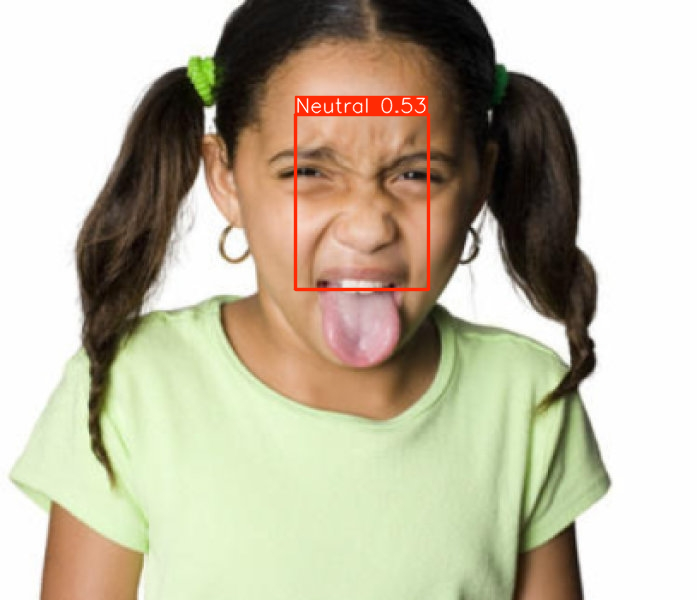

,x1,y1,x2,y2,confidence,class_id,class_name
0,295.704407,114.884796,428.214935,289.847565,0.526817,0,Neutral


Annotated image saved → ntbk_outputs\cl5sn4ab7c511e353h_annotated.jpg
CSV saved to: ntbk_outputs\cl5sn4ab7c511e353h_detections.csv


In [15]:

# --- Single image ---
IMAGE_PATH = Path("cl5sn4ab7c511e353h.jpg")  
if IMAGE_PATH.exists():
    img = Image.open(IMAGE_PATH).convert("RGB")
    results_list = model.predict(
        source=np.array(img),
        conf=CONF_THRES, iou=IOU_THRES, device=DEVICE,
        imgsz=int(IMG_SIZE), max_det=int(MAX_DET),
        agnostic_nms=AGNOSTIC_NMS, half=FP16, verbose=False
    )
    res = results_list[0]
    ann = annotate_image(res)
    display(ann)
    df = results_to_df(res)
    display(df)

    # Save outputs
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    out_img = OUTPUT_DIR / f"{IMAGE_PATH.stem}_annotated.jpg"
    ann.save(out_img)
    print(f"Annotated image saved → {out_img}")
    if not df.empty:
        save_df(df, OUTPUT_DIR / f"{IMAGE_PATH.stem}_detections.csv")
else:
    print("Update IMAGE_PATH to a valid image file.")



## Webcam snapshot (single frame)
Captures a single frame from your default camera, runs detection, and saves an annotated image + CSV.


In [ ]:

# --- Webcam snapshot ---
USE_WEBCAM = True   
if USE_WEBCAM:
    import cv2
    cap = cv2.VideoCapture(0)
    ok, frame = cap.read()
    cap.release()
    if ok:
        # BGR -> RGB PIL
        img = Image.fromarray(frame[:, :, ::-1])
        display(img)
        results_list = model.predict(
            source=np.array(img),
            conf=CONF_THRES, iou=IOU_THRES, device=DEVICE,
            imgsz=int(IMG_SIZE), max_det=int(MAX_DET),
            agnostic_nms=AGNOSTIC_NMS, half=FP16, verbose=False
        )
        res = results_list[0]
        ann = annotate_image(res)
        display(ann)
        df = results_to_df(res)
        display(df)

        OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
        out_img = OUTPUT_DIR / "webcam_snapshot_annotated.jpg"
        ann.save(out_img)
        print(f"Saved annotated snapshot → {out_img}")
        if not df.empty:
            save_df(df, OUTPUT_DIR / "webcam_snapshot_detections.csv")
    else:
        print("Could not read from webcam. Check permissions/camera index.")
else:
    print("Set USE_WEBCAM=True to capture a frame.")



## Plot training metrics (optional)
Point `RESULTS_CSV` to your `runs/detect/train/results.csv` to visualize loss/metrics curves.


In [ ]:

# --- Metrics plotting ---
RESULTS_CSV = Path("runs/detect/train/results.csv")  # <-- update if needed

if RESULTS_CSV.exists():
    df = pd.read_csv(RESULTS_CSV)
    print("Columns:", list(df.columns))

    metrics = ["train/box_loss", "train/cls_loss", "train/dfl_loss",
               "metrics/mAP50-95(B)", "metrics/precision(B)", "metrics/recall(B)"]
    for m in metrics:
        if m in df.columns:
            plt.figure()
            plt.plot(df[m])
            plt.title(m)
            plt.xlabel("epoch")
            plt.ylabel(m)
            plt.show()
else:
    print("results.csv not found. Train a model or update RESULTS_CSV path.")


checking something

In [9]:
from model import model_output, model_selection

obj = model_output(upload=False, webcam = True)

orig, ann, df = obj.run_model()
display(orig)
display(ann)
print(df)

AttributeError: 'NoneType' object has no attribute 'convert'